# **Quantum-enhanced Monte Carlo markov chain optimization**

The combination of classical Monte Carlo Markov chains (MCMC) methods with quantum computers showed potential for achieving quantum advantage in sampling from complex probability distributions, a computationally hard task arising in many diverse fields [1]. Quantum-enhanced proposal distributions, defined by parameterized unitaries $U(\bar{\theta})$, could outperform classical strategies in proposing effective moves in MCMC. However, it is crucial to carefully tune the values of the parameters $\bar{\theta}$ defining the quantum proposal distribution, as they determine the resulting advantage over the classical counterpart. A general optimization method becomes essential when considering problems where is not possible to identify a reasonable parameter set. This could happen when adopting complicated proposal strategies depending on a large number of parameters, or simply when no prior or relevant information about the problem is available.

In the following, a general optimization approach that exploits estimates of the autocorrelation function of a certain observable $f$ to optimize the parameters defining the quantum proposal distribution is presented. In order to analyze the performance of the optimization algorithm the spectral gap $\delta$ and the cost function value are monitored during the optimization.

### **The algorithm**

Let $S$ be the state space of all the possible states $\boldsymbol{s}$. Let $f: S → \mathbb{R}$ be a real-valued function defined on $S$. $\bar{\theta}$ will be the set of parameters, defining the quantum proposal distribution $Q(\boldsymbol{s'}|\boldsymbol{s})=|\langle \boldsymbol{s}|U(\bar{\theta})|\boldsymbol{s'}\rangle |^2$ we aim to optimize. With $Loss$, instead, we will refer to the loss function based on the autocorrelation of th observable $f$. Finally, let $R$ be an array where we can store partial results during the computation.

[comment]: <![qmcmc_opt](images/qmcmc_optimizer_pic.png)>

<div style="text-align:center">
    <img src="images/qmcmc_optimizer_pic.png" alt="qmcmc_opt" width="900px" />
        <p style="text-align:center">
        High-level representation of the Quantum-enhanced MCMC optimization algorithm. The algorithm starts by running a Quantum-enhanced Markov chain: it evolves
the current computational basis state |s⟩ under U (1), the evolved state |ψ⟩ is then
measured in the computational basis (2) and the measurement result is either accepted or
rejected according to the Metropolis-Hastings probabilities (3). An observable is evaluated over the new spin configuration and, finally, the spin configuration is mapped onto
a computational basis state (4) that constitutes the starting point for the successive step.
Once a certain number n of samples has been gathered, a $Loss$ function is evaluated over
these samples (5) and the resulting value is fed to the classical optimizer which provides
then new parameter values for the parametrized quantum circuit implementing the quantum state proposal (6).
        </p>
</div>

Let $S$ be the state space of all the possible states $\boldsymbol{s}$. Let $f: S → \mathbb{R}$ be a real-valued function defined on $S$. $\bar{\theta}$ will be the set of parameters, defining the quantum proposal distribution $Q(\boldsymbol{s'}|\boldsymbol{s})=|\langle \boldsymbol{s}|U(\bar{\theta})|\boldsymbol{s'}\rangle |^2$ we aim to optimize. With $Loss$, instead, we will refer to the loss function based on the autocorrelation of th observable $f$. Finally, let $R$ be an array where we can store partial results during the computation.

The optimization algorithm iteratively updates the parameters $\bar{\theta}$ defining the quantum proposal distribution until the $Loss$ function value converges to a minimum. It consists of a feedback loop that runs quantum-enhanced Markov chains to evaluate the $Loss$ function and optimize the proposal strategy. As shown in the picture, at each iteration we run a quantum-enhanced Markov chain proposing moves using the current proposal distribution $Q(s'|s)$, and
we record the visited states ${\boldsymbol{s_0}, \boldsymbol{s_1}, \boldsymbol{s_2}, ...}$. For each visited state $\boldsymbol{s}$, an observable $f(\boldsymbol{s})$ is evaluated and stored in the register $R$. The observable choice depends on the specific problem we are dealing with and on the Loss function we want to use. Once a set number $n$ of MC steps has been performed, we then evaluate the $Loss$ function over the $n$ samples and pass the value to the classical optimizer. The classical optimizer provides then new parameter values for the parametrized quantum circuit implementing the quantum state proposal $U(\bar{\theta})$. This routine is repeated until either the $Loss$ converges or we reach a maximum number of iterations.

### **The code implementation**

The specific problem we address in the following is the optimization of the parametrized ansatz $U(\gamma, t)$, proposed by Layden et al. [1], that samples from the Boltzmann probability distribution of classical Ising models outperforming classical Monte Carlo Markov chain methods at low temperatures.

##### ***REFERENCES***

[1] David Layden et al., “Quantum-enhanced Markov chain Monte Carlo”, AirXiv (2022),
doi: 10.48550/ARXIV.2203.12497, url: https://arxiv.org/abs/2203.12497



#### Imports

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt

from q_systems import SpinSystem
from qmcmc_classes import *

#### Defining the energy model



          MODEL : 2D_Ising_random_mean_0_sd_1
Non-zero Interactions (J) : 15 / 15
Non-zero Bias (h) : 6 / 6
------------------------------------------------------------
Average Interaction Strength <|J|>:  0.886
Average Bias Strength <|h|>:  0.747
------------------------------------------------------------


Spins coupling heatmap: 



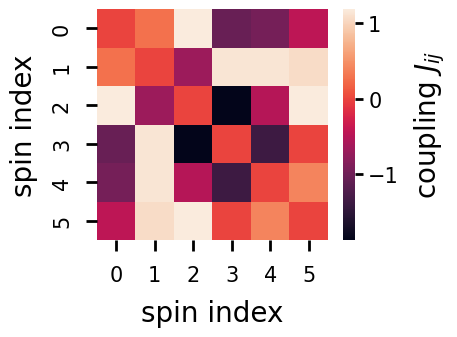

In [3]:
# number of spins
n_spins = 6
# temperature
T = 10
# random seed 
# numpy.random.seed(630201)
# model instance
model_instance = IsingModel_2D(n_spins, random=True)
J = model_instance.J  # couplings 
h = model_instance.h  # fields
# initialize spin system
spin_system = SpinSystem(n_spins, T, J, h)
# printing model summary
model_instance.summary(plot=True)

#### Setting up the QMCMC optimizer 

In [6]:
# ansatz class
ansatz = IBM_Ansatz 
# length of the chains used to gather the samples and evaluate the cost function
mc_length = 2000
# number of initial samples to discard
discard = n_spins*1e3
# cost function
cost_f_choice = 'ACF'
lag = 'integral'
#
average_over = 1  #TODO: remove
# initial parameters guess
params_dict = {'gamma': 0.16, 'tau': 2}
# observable 
observable = 'energy'
# optimization approach
optimization_approach = 'concatenated_mc'
# initializing the QMCMC optimizer
qmcmc_optimizer = QMCMC_Optimizer(spin_system, ansatz, mc_length, average_over=average_over,
                   cost_f_choice=cost_f_choice, optimization_approach=optimization_approach,
                   verbose=False, initial_transient=discard, observable=observable, lag=lag)

#### Setting up classical optimizer

In [7]:
# optimization boundaries
bnds = ((0.1, 1), (1, 10))
# minimization algorithm
optimizer ='Nelder-Mead'
# define initial simplex
# initial_simplex = array_like of shape (N + 1, N)
# accuracy
# fatol =  float
# max size of the simplex
# xatol =  float
# max number of iterations per optimization cycle
# maxiter = int

#### Optimizing the quantum proposal distribution

In [8]:
# saving initial parameters guess in a string
params_guess = numpy.fromiter(params_dict.values(), dtype=float)
params_string = '_'
for param_name, value in params_dict.items():
    params_string += param_name + f'_{round(value, 3)}_'
# include the initial params values and corresponding spectral gap value in the DataFrame containing
# the optimization results
# cost_f = qmcmc_optimizer(params_guess, qmcmc_optimizer.current_state)
# qmcmc_optimizer.get_save_results(params=params_guess, cost_f=cost_f)

In [9]:
while data_to_collect(qmcmc_optimizer, max_iteration=35e3): 

    # saving the current state (used when optimization_approach='same_start_mc')
    args = (qmcmc_optimizer.current_state)
    # minimizing the cost funciton
    results = scipy.optimize.minimize(qmcmc_optimizer, x0=params_guess, args=args, 
                  method=optimizer, bounds=bnds, options = {
                  'adaptive': True if params_guess.size > 3 else False, 'initial_simplex': None})
    # updating the parameters guess
    params_guess = results.x
    # optimizing lag value
    if isinstance(qmcmc_optimizer.lag, dict):
        qmcmc_optimizer.optimize_lag()
    # saving the current results
    qmcmc_optimizer.get_save_results(results=results)

# printing out termination message
print('\nOptimization terminated with:', qmcmc_optimizer.iteration, 'loss function evaluations\n')



Optimization terminated with: 35200 loss function evaluations



#### Saving the results in a file

In [ ]:
# saving the results
# csv_name = 'QMCMC_optimization_' + params_string + '.csv'
# qmcmc_optimizer.db.to_csv(csv_name, encoding='utf-8')
# print('\nSaved results to csv file: ' + csv_name + '\n')

#### Plotting the results

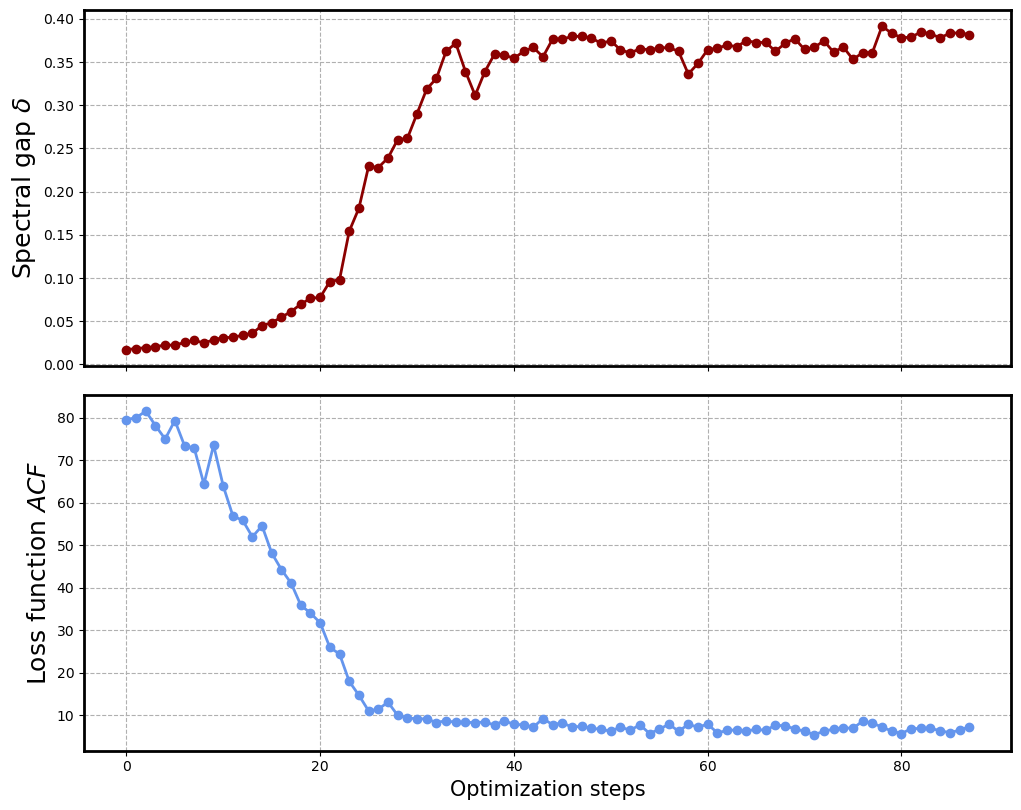

In [10]:
# converting the DataFrame containing the result in numpy arrays
spectral_gap = numpy.array(qmcmc_optimizer.db['spectral gap'])
cost_function = numpy.array(qmcmc_optimizer.db['cost f'])
# plotting the results
figure, axis = plt.subplots((2), figsize=(10, 8), dpi=100)
figure.tight_layout(h_pad=0, w_pad=4)  # spacing between subplots
# spectral gap
axis[0].plot(range(spectral_gap.size), spectral_gap, marker='o', color='darkred',
                  label='$\delta$', linestyle='-', lw=2)
axis[0].grid(linestyle='--')
axis[0].set_xticklabels([])
axis[0].set_ylabel('Spectral gap $\delta$', fontsize=18)
#axis[0][0].set_ylim(0, 1)
for ax in ['top','bottom','left','right']:
    axis[0].spines[ax].set_linewidth(2)
# cost function
axis[1].plot(range(cost_function.size), cost_function, marker='o', color='cornflowerblue',
                  label='cost function', linestyle='-', lw=2)
axis[1].grid(linestyle='--')
axis[1].set_xlabel('Optimization steps', fontsize=15)
axis[1].set_ylabel('Loss function $' + cost_f_choice + '$', fontsize=18)
for ax in ['top','bottom','left','right']:
    axis[1].spines[ax].set_linewidth(2)